### *0*. Import libraries and connect Google Drive

In [0]:
# Generic libs
import numpy as np
import pandas as pd
import random
import os

# Make it pretty
import matplotlib.pyplot as plt # Make plots
from tqdm import tqdm           # Shows status bar on loops (really cool)

# Machine learning libs
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt 
from scipy.spatial.distance import cdist
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Neural network libs
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

# File mgmt libs
import pickle
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/




### *1*. Define configurations

In [0]:
# Sets global parameters for the network in order to properly build it and fit
# our imported data
import random
random.seed(1234) # initialize internal state from hashable object

class Config():
    def __init__(self):
        self.frame_l = 50  # number of frames [fixed by the paper] (=1.28 sec)
        self.joint_n = 25   # number of joints [we could use less]
        self.joint_d = 3    # spatial dimension of joints [2D/3D]
        self.clc_num = 6    # number of classes [14/28 gesture in their paper]
        self.feat_d  = 300  # JCD dimensionality (lower matrix) [(17^2-17)/2]
        self.filters = 32   # how many filters in a layer
C = Config()

### *2*. Define data processing functions

In [0]:
# Temple resizing function | target_l -> frame_l
def zoom(p,target_l=50,joints_num=25,joints_dim=3): # 25 joints in 3D space
    l = p.shape[0]  # number of frames as imported
    # added to tranform our 2D data into a tensor (3D)
    p = np.transpose(p)
    p = np.reshape(p, (l, joints_num, joints_dim))
    
    p_new = np.empty([target_l,joints_num,joints_dim])  # empty 124x25x3 tensor
    for m in range(joints_num):
        for n in range(joints_dim):
            p_new[:,m,n] = medfilt(p_new[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]         
    return p_new


# Normalize JCD with respect to the mean value
def norm_scale(x):
    return (x-np.mean(x))/np.mean(x)


# Calculate JCD matrix
def get_CG(p,C):  
    M = []
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l): 
        d_m = cdist(p[f],p[f],'euclidean')  # euclidean dist between all joints
        d_m = d_m[iu] 
        M.append(d_m)
    M = np.stack(M)  # Join a sequence of arrays along a new axis.
    M = norm_scale(M)  # noralize with respect to the mean value
    return M
  
  
# Generate dataset: M = JCD, P = motion
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose'])), ncols = 100):  # nerve-racking way of looping with an index in Py
        p = np.copy(T['pose'][i]) # mette in p le coordinate estratte da un file
        # print(p.shape) 125x75
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

        label = np.zeros(C.clc_num)  # number of classes
        label[le.transform(T['label'])[i]-1] = 1   

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

### *3*. Define network

In [0]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,:1,...],x[:,:-1,...]) # ignore 3rd dimension in case it doesn't exist
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16): # joint_n = 22 joint, frame_l = 32 frame, 
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


def build_GR_Net(C):
    # M: distances
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  # 125 frame x 300 JCD
    # P: motion
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d))  # 125 frame x 25 joints x 3 dimensions
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x) # GAP
    
    x = d1D(x,128)  # FC fully connected 128
    x = Dropout(0.5)(x)
    x = d1D(x,128)  # FC fully connected 128
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x) # FC(num_classes)
    
    # Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [0]:
GR_Net = build_GR_Net(C)
GR_Net.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 50, 300)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 50, 25, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 6, 256)       454784      M[0][0]                          
                                                                 P[0][0]                          
_______________________________________________________________________

### *4*. Load dataset (use pkl file from google drive)

Samples in Train: 4020
Samples in Test: 1724


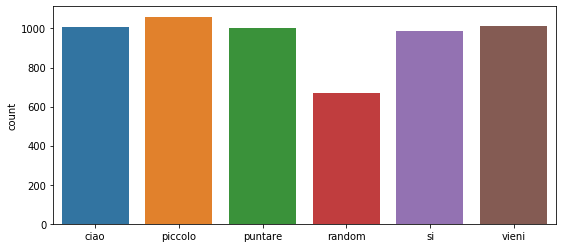

In [0]:
# import the whole database as .pkl
TrainTest_p = "/content/drive/My Drive/Dataset_lab/TrainTest_N_M_NM30.pkl"
TrainTest = pickle.load(open(TrainTest_p, "rb"))

le = preprocessing.LabelEncoder() # converts the numbers to names (labels)
le.fit(TrainTest['label'])

# split it in train and test and keep X and Y separated
X_train, X_test, y_train, y_test = train_test_split(TrainTest['pose'], TrainTest['label'], 
                                                    test_size = 0.30, # by default is 75%-25%
                                                    # shuffle is set True by default,
                                                    stratify = TrainTest['label'],
                                                    random_state = 123) # fix random seed for replicability

# merge: Train = X_train + y_train && Test = X_test + y_test
Train = {'pose': X_train, 'label': y_train}
Test = {'pose': X_test, 'label': y_test}

print('Samples in Train: '+str(len(Train['pose'])))
print('Samples in Test: '+str(len(Test['pose'])))

# plot some info about what was imported
import seaborn as sns
plt.figure(figsize=(9,4))
k = ['ciao', 'piccolo', 'puntare', 'random', 'si', 'vieni']
sns.countplot(x='label',data=TrainTest,order=k);

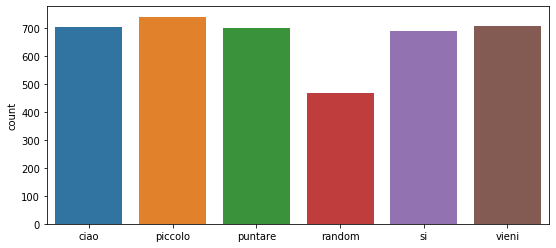

In [0]:
plt.figure(figsize=(9,4))
sns.countplot(x='label', data=Train, order=k);

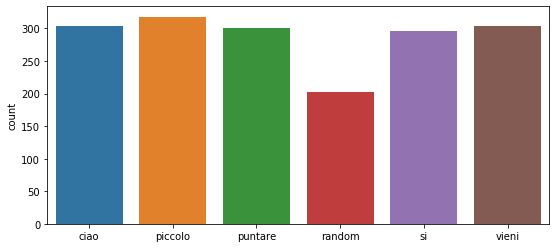

In [0]:
plt.figure(figsize=(9,4))
sns.countplot(x='label', data=Test, order=k);

In [0]:
X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|███████████████████████████████████████████████████████████| 1724/1724 [00:21<00:00, 80.23it/s]


In [0]:
#print(y_test)
#print(np.argmax(Y_test, axis=1))

### *5*. Train the model

In [0]:
import keras
lr = 1e-3
GR_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = GR_Net.fit([X_0,X_1],Y,
                    batch_size = 32,  # len(Y) | None = online gradient update
                    epochs = 300,
                    verbose = True,
                    shuffle = True,  # shuffle the data at each iteration
                    callbacks = [lrScheduler],
                    validation_data = ([X_test_0,X_test_1],Y_test)
                    )
# objective is to have a good validation accuracy! (you're shure there's no overfitting)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4020 samples, validate on 1724 samples
Epoch 1/300





4020/4020 [==============================] - 18s 5ms/step - loss: 2.1747 - acc: 0.1873 - val_loss: 1.7520 - val_acc: 0.2807
Epoch 2/300
4020/4020 [==============================] - 6s 1ms/step - loss: 1.8731 - acc: 0.2343 - val_loss: 1.8115 - val_acc: 0.2929
Epoch 3/300
4020/4020 [==============================] - 6s 1ms/step - loss: 1.6680 - acc: 0.3117 - val_loss: 1.4015 - val_acc: 0.4623
Epoch 4/300
4020/4020 [==============================] - 6s 1ms/step - loss: 1.4264 - acc: 0.4249 - val_loss: 1.2576 - val_acc: 0.4901
Epoch 5/300
4020/4020 [==============================] - 6s 1ms/step - loss: 1.1926 - acc: 0.5007 - val_loss: 1.2733 - val_acc: 0.5116
Epoch 6/300
4020/4020 [==============================] - 6s 1ms/step - loss: 1.0725 - acc: 0.5413 - val_loss: 0.9458 - val_acc: 0.6050
Epoch 7/300
4020/4020 [==============

### *6* Visualize the performance of the neural network

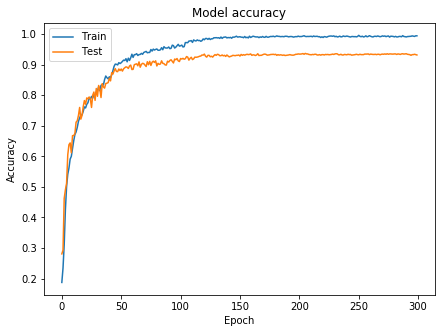

In [0]:
# Plot training & validation accuracy values
plt.rcParams['figure.figsize'] = [7, 5]
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

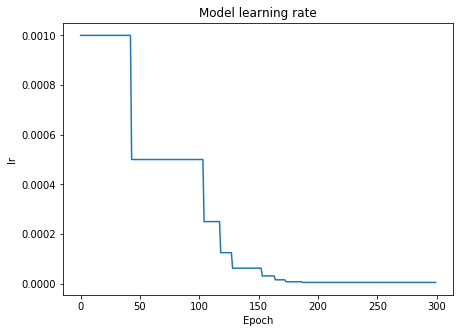

In [0]:
# plot learning rate to see what's going on
plt.rcParams['figure.figsize'] = [7, 5]
plt.plot(history.history['lr'])
plt.title('Model learning rate')
plt.ylabel('lr')
plt.xlabel('Epoch')
plt.show()

In [0]:
# Show confusion matrix
from sklearn.metrics import confusion_matrix
GR_net_predictions = GR_Net.predict([X_test_0,X_test_1], batch_size=None)  # predict da softmax (6 valori da 0 a 1 per file)
GR_net_predictions_round = np.argmax(GR_net_predictions,axis=1) # prendo il massimo di questi 6 valori e ricavo la classe numerica

GR_net_test_round = np.argmax(Y_test,axis=1)  # ricava la classe numerica partendo dalla probabilita'
CM = confusion_matrix(GR_net_test_round, GR_net_predictions_round)

Normalized confusion matrix


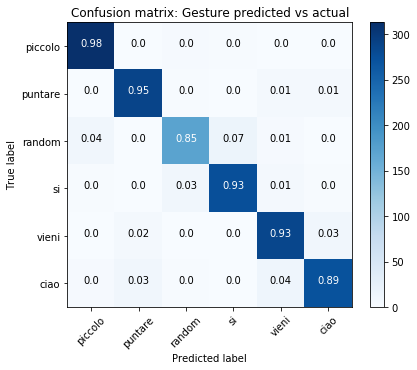

In [0]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import itertools
%matplotlib inline

def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        for i, arr in enumerate(cm):
            for j, val in enumerate(cm[0]):
                cm[i][j] = truncate(cm[i][j], 2) 
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['piccolo', 'puntare', 'random', 'si', 'vieni', 'ciao']
plt.rcParams['figure.figsize'] = [6, 5]
plot_confusion_matrix(CM, cm_plot_labels, title = 'Confusion matrix: Gesture predicted vs actual')
plt.show()

In [0]:
# plt.figure(figsize=(5,4))
# x_axis_labels = ['piccolo', 'puntare', 'random', 'si', 'vieni', 'ciao'] # labels for x-axis
# y_axis_labels = ['piccolo', 'puntare', 'random', 'si', 'vieni', 'ciao'] # labels for y-axis
# sns.heatmap(CM, annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels);
# # sns.heatmap(CM, cm_plot_labels)

In [0]:
#print(y_test)
#print(GR_net_test_round)
# puntare 1
# si 3
# ciao 5
# vieni 4
# piccolo 0
# random 2

In [0]:
# title = "confusion matrix"
# disp = plot_confusion_matrix(CM, Y_test,
#                             display_labels=class_names,
#                             cmap=plt.cm.Blues,
#                             normalize=normalize)
# disp.ax_.set_title(title)

# print(title)
# print(disp.confusion_matrix)

# plt.show()